In [1]:
'''

1. Under the pw-rigid approach, the FOV in any given frame is split into a set of overlapping patches 
(Fig. 1b) with user determined dimensions and amount of overlap. 
2. Each patch is registered against the template, restricted to the same part of the FOV, at a subpixel resolution. 
3. Next, each patch is further split into smaller overlapping subpatches and similarly, 
the computed displacement vectors for the set of the initial patches are upsampled to create a smooth motion field. 
4. This associates to each subpatch a new translation vector that is subsequently rigidly applied to it (Fig. 1b). 
5. The registered subpatches are then embedded and interpolated within the original FOV to obtain the registered frame. 
6. That frame is also used to update the template in the online scenario as discussed in the following section. 
'''

'\n\n1. Under the pw-rigid approach, the FOV in any given frame is split into a set of overlapping patches \n(Fig. 1b) with user determined dimensions and amount of overlap. \n2. Each patch is registered against the template, restricted to the same part of the FOV, at a subpixel resolution. \n3. Next, each patch is further split into smaller overlapping subpatches and similarly, \nthe computed displacement vectors for the set of the initial patches are upsampled to create a smooth motion field. \n4. This associates to each subpatch a new translation vector that is subsequently rigidly applied to it (Fig. 1b). \n5. The registered subpatches are then embedded and interpolated within the original FOV to obtain the registered frame. \n6. That frame is also used to update the template in the online scenario as discussed in the following section. \n'

In [2]:
import numpy as np
import h5py
import time
from typing import Tuple

In [3]:
file='C:/Users/koester_lab/Documents/Maria/registered/fish_11_6df_medium_aligned.h5'
plane_ind=10

In [4]:
with h5py.File(file, "r") as f:
    print("Loading detrended data from plane: "+str(plane_ind))
    start=time.time()
    dat=f['data'][:,plane_ind,:,:].astype('float32')
    end=time.time()
    print('Time to load detrended plane data file: ',end-start)

Loading detrended data from plane: 10
Time to load detrended plane data file:  3.5898492336273193


In [5]:
#One
def kernelD2(xs: int, ys: int) -> np.ndarray:
    """
    Parameters
    ----------
    xs
    ys

    Returns
    -------

    """
    ys, xs = np.meshgrid(xs, ys)
    ys = ys.flatten().reshape(1, -1)
    xs = xs.flatten().reshape(1, -1)
    R = np.exp(-((ys - ys.T) ** 2 + (xs - xs.T) ** 2))
    R = R / np.sum(R, axis=0)
    return R

def calculate_nblocks(L: int, block_size: int = 128) -> Tuple[int, int]:
    """
    Returns block_size and nblocks from dimension length and desired block size

    Parameters
    ----------
    L: int
    block_size: int

    Returns
    -------
    block_size: int
    nblocks: int
    """
    return (L, 1) if block_size >= L else (block_size, int(np.ceil(1.5 * L / block_size)))


def make_blocks(Ly, Lx, block_size=(128, 128)):
    """
    Computes overlapping blocks to split FOV into to register separately

    Parameters
    ----------
    Ly: int
        Number of pixels in the vertical dimension
    Lx: int
        Number of pixels in the horizontal dimension
    block_size: int, int
        block size

    Returns
    -------
    yblock: float array
    xblock: float array
    nblocks: int, int
    block_size: int, int
    NRsm: array
    """

    block_size_y, ny = calculate_nblocks(L=Ly, block_size=block_size[0])
    block_size_x, nx = calculate_nblocks(L=Lx, block_size=block_size[1])
    block_size = (block_size_y, block_size_x)

    # todo: could rounding to int here over-represent some pixels over others?
    ystart = np.linspace(0, Ly - block_size[0], ny).astype('int')
    xstart = np.linspace(0, Lx - block_size[1], nx).astype('int')
    yblock = [np.array([ystart[iy], ystart[iy] + block_size[0]]) for iy in range(ny) for _ in range(nx)]
    xblock = [np.array([xstart[ix], xstart[ix] + block_size[1]]) for _ in range(ny) for ix in range(nx)]

    NRsm = kernelD2(xs=np.arange(nx), ys=np.arange(ny)).T

    return yblock, xblock, [ny, nx], block_size, NRsm

In [6]:
yblock, xblock, [ny, nx], block_size, NRsm=make_blocks(1024,1024)
print(len(yblock))
print(ny)
print(nx)
print(xblock)

144
12
12
[array([  0, 128]), array([ 81, 209]), array([162, 290]), array([244, 372]), array([325, 453]), array([407, 535]), array([488, 616]), array([570, 698]), array([651, 779]), array([733, 861]), array([814, 942]), array([ 896, 1024]), array([  0, 128]), array([ 81, 209]), array([162, 290]), array([244, 372]), array([325, 453]), array([407, 535]), array([488, 616]), array([570, 698]), array([651, 779]), array([733, 861]), array([814, 942]), array([ 896, 1024]), array([  0, 128]), array([ 81, 209]), array([162, 290]), array([244, 372]), array([325, 453]), array([407, 535]), array([488, 616]), array([570, 698]), array([651, 779]), array([733, 861]), array([814, 942]), array([ 896, 1024]), array([  0, 128]), array([ 81, 209]), array([162, 290]), array([244, 372]), array([325, 453]), array([407, 535]), array([488, 616]), array([570, 698]), array([651, 779]), array([733, 861]), array([814, 942]), array([ 896, 1024]), array([  0, 128]), array([ 81, 209]), array([162, 290]), array([244, 

In [14]:
bl_x=xblock[70]
bl_y=yblock[70]
one_patch=dat[0,bl_x[0]:bl_x[1],bl_y[0]:bl_y[1]]

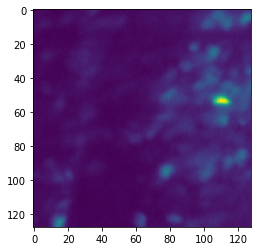

In [15]:
import matplotlib.pyplot as plt
plt.imshow(one_patch)